# **CUDA Programming in Juypter Notebook for Beginners**

This notebook is designed to guide others through the foundations of CUDA programming, demonstrating how to leverage NVIDIA GPUs for high-performance computing tasks within a Jupyter Notebook. As a data science student, creating this artifact to document and share my learning is invaluable and full of teachable moments. This is only an initial exploration of CUDA programming and use, but it serves as a good resource for future, more advanced projects.

### **Why CUDA is Valuable for Data Science:**
**CUDA** (Compute Unified Device Architecture) enables you to perform general-purpose computations on GPUs, providing massive parallel processing power. For data science, this means faster performance when handling tasks like:
- Accelerating data processing and analysis
- Optimizing machine learning algorithms
- Writing custom CUDA kernels for specialized tasks

Mastering CUDA can enhance your ability to work with large datasets and computationally intensive models, leading to more efficient workflows and quicker results.

See the official documentation for CUDA here: https://docs.nvidia.com/cuda/cuda-c-programming-guide/

Before you get started, make sure you have the following installed:
- NVIDIA GPU with CUDA support
- [CUDA Toolkit](https://developer.nvidia.com/cuda-downloads)

### **Learning Objectives & What Was Accomplished**

1) **Setting Up CUDA:** By following the steps above, I’ve learned how to configure a Conda environment, install the required dependencies, and ensure that Jupyter can access the GPU for computation.

2) **Benchmarking CPU vs. GPU Performance:** By replacing NumPy with CuPy, I was able to benchmark the performance difference between CPU and GPU for element-wise operations. This highlighted the performance boost offered by the GPU for certain tasks, demonstrating when and why it might be beneficial to use the GPU over the CPU.

3) **Writing Custom CUDA Kernels:** Using CuPy’s RawKernel, I created a custom CUDA kernel to perform an element-wise multiplication, enabling me to execute GPU-accelerated computations directly within Python.

These tasks have not only expanded my understanding of how GPUs can be used in data science but also provided practical insights into optimizing workflows using CUDA.

---


### **1) Steps to Run Jupyter Notebook on GPU (this was frustrating)**

Ah, the joys of setting up CUDA... the road to GPU acceleration is paved with dependencies, obscure errors, and cryptic warning messages. These steps should circumvent those issues I experienced.

Make sure to install the required Packages:
```bash
!pip install numpy cupy
```

1. Create a New Conda Environment
First, open a command prompt with admin privileges and run the following command to create a new Conda environment named gpu2:
```bash
conda create -n gpu2 python=3.6
```

2. Verify Available Environments
Run the following command to list all available Conda environments:
```bash
conda info -e
```

3. Activate the Environment
Activate the newly created environment using the command:
```bash
conda activate gpu2
```

4. Install TensorFlow-GPU
Install TensorFlow-GPU version 2.3.0 (or any other compatible version) with the following command:
```bash
pip install tensorflow-gpu==2.3.0
```

5. Install Jupyter and Ipykernel
Install Jupyter Notebook and the Ipykernel package to create a kernel for the GPU environment:
```bash
pip install ipykernel
```

Next, install the kernel to allow Jupyter to recognize the environment:
```bash
python -m ipykernel install --user --name=gpu2 --display-name "Python (CUDA)"
```

Now you can select your environment in the Jupyter GUI.

#### See below for what the top right should look like with your new environment selected:
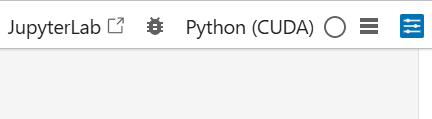

---


In [2]:
# We can begin with checking the CUDA verison (the '!' lets us run system commands)
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2025 NVIDIA Corporation
Built on Fri_Feb_21_20:42:46_Pacific_Standard_Time_2025
Cuda compilation tools, release 12.8, V12.8.93
Build cuda_12.8.r12.8/compiler.35583870_0


In [3]:
# Now we can check the GPU status next (hopefully my GPU is sufficient for the gamers out there)
!nvidia-smi 

Fri Mar 14 18:47:50 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 572.61                 Driver Version: 572.61         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070      WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   47C    P8             12W /  200W |    1731MiB /  12282MiB |     19%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### **Additional Setup Instructions**

This is going back to the initial setup, resource at: https://docs.cupy.dev/en/stable/install.html

See below for version to install based on the output of the command above, top right- for CUDA Version applicable to your system.
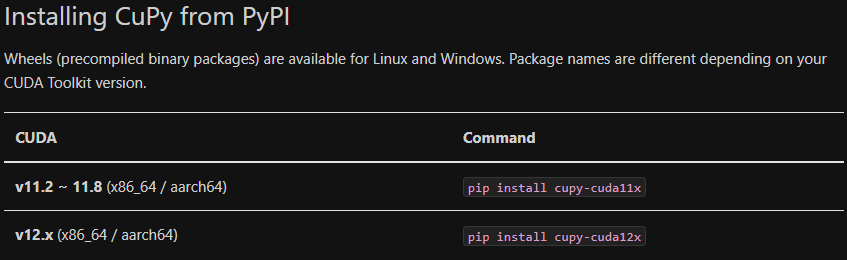


## **2) Using CuPy for Comparing CPU and GPU Computation**

CuPy is a GPU-accelerated library, similar to NumPy, that allows us to perform computations on NVIDIA GPUs. In this section, we’ll compare the performance of element-wise multiplication on the CPU and GPU to highlight how CuPy can speed up tasks by leveraging parallel processing on the GPU.

In [6]:
# Adding in the required imports
import cupy as cp
import numpy as np
import time

In [7]:
# Creating large arrays on CPU (NumPy)
x_cpu = np.random.rand(100000).astype(np.float32)
y_cpu = np.random.rand(100000).astype(np.float32)

In [8]:
# Create the same arrays on GPU (CuPy)
x_gpu = cp.array(x_cpu)
y_gpu = cp.array(y_cpu)

In [9]:
# CPU Computation
t1 = time.time()
result_cpu = x_cpu * y_cpu
t2 = time.time()
print(f"CPU Time: {t2 - t1:.6f} sec")

CPU Time: 0.000000 sec


In [10]:
# GPU Computation
t1 = time.time()
result_gpu = x_gpu * y_gpu
cp.cuda.Device(0).synchronize() # Ensure the GPU computation is done
t2 = time.time()
print(f"GPU Time: {t2 - t1:.6f} sec")

GPU Time: 0.025532 sec


Sometimes the CPU can perform faster than the GPU if the sample is small enough, which is what I tried to present here. It cannot fully represent the computational power (paralell processing) the GPUs offer, as CPUs do great with SMALL data sets. 

Below are the reasons why this can occur:

##### **Lessons Learned from the comparison of CPU vs GPU**

1. **Data Transfer Overhead:** Moving data between the CPU and GPU takes time. For smaller datasets, the cost of transferring data outweighs the computational speedup provided by the GPU.
2. **Task Size:** GPUs shine with larger, more complex tasks. Small-scale operations (like element-wise multiplication of arrays with 10 million elements) don't fully leverage the GPU's parallel processing capabilities, leading to slower performance compared to the CPU.
3. **GPU Setup Time:** The initial overhead of setting up the GPU, including memory allocation and kernel launch, can slow down small operations, especially when compared to the more efficient CPU execution.

---

### Optimizing GPU Usage by Reusing Data

The CPU is performing slightly faster than the GPU. We need to find a way to stress a higher load in order to see who does better under pressure. We will keep the data on the GPU for mulitple operations, avoiding more overhead with the transferring of data back and fourth between the CPU and GPU. 

By reusing data on the GPU, we can better utilize the parallel processing power of the GPU and reduce unecessary setup times.

In [14]:
# Create larger arrays on CPU (NumPy) - 10 million elements
x_cpu = np.random.rand(10000000).astype(np.float32)
y_cpu = np.random.rand(10000000).astype(np.float32)

In [15]:
# Transfer the arrays to the GPU (CuPy)
x_gpu = cp.array(x_cpu)  # Transfer x_cpu to GPU
y_gpu = cp.array(y_cpu)  # Transfer y_cpu to GPU

In [16]:
# CPU Computation (Single Operation)
t1 = time.time()
result_cpu = x_cpu * y_cpu  # Perform element-wise multiplication on CPU
t2 = time.time()
print(f"CPU Time: {t2 - t1:.6f} sec")

CPU Time: 0.008142 sec


In [17]:
# GPU Computation (First Operation)
t1 = time.time()
result_gpu = x_gpu * y_gpu  # Perform element-wise multiplication on GPU
cp.cuda.Device(0).synchronize()  # Ensure GPU computation is done before timing
t2 = time.time()
print(f"GPU Time (First Operation): {t2 - t1:.6f} sec")

GPU Time (First Operation): 0.002000 sec


In [18]:
# GPU Computation (Second Operation) - Reusing the data already stored on the GPU to avoid transfer overhead
t1 = time.time()
result_gpu2 = x_gpu * y_gpu  # Reuse the same GPU data for a second operation
cp.cuda.Device(0).synchronize()  # Ensure GPU computation is done before timing
t2 = time.time()
print(f"GPU Time (Reused Data): {t2 - t1:.6f} sec")

GPU Time (Reused Data): 0.002003 sec


##### **Lessons Learned from the comparison of CPU vs GPU (with second round)**

The GPU performed significantly faster, especially in the second round with data reuse. This is due to the massive nubmer of cores available for parallel processing. Unlike CPUs, which typically have a small number of cores optimized for sequential tasks, GPUs can have thousands of cores designed to handle many operations simultaneously. 

This makes GPUs highly efficent for tasks like element-wise multiplications on large datasets, where parallelism can be fully leveraged. The data reuse in the second round also helped avoid transfer overhead, allowing the GPU to perform optimally.

---

## **3) Writing Custom CUDA Kernels**

In addition to using CuPy for simple array operations, we can write our own CUDA kernels directly within Python using CuPy's `RawKernel`. This allows us to fully customize how the GPU performs certain computations. Understanding how to write custom kernels is valuable because it opens up the possibility of optimizing algorithms to run more efficiently on the GPU for large-scale data processing tasks

---
This kernel, written in CUDA C, performs element-wise multiplication of two arrays (x and y) and stores the result in out. It runs on the GPU using parallel threads for efficient computation.

In [45]:
# Define CUDA Kernel using CuPy's RawKernel
cuda_kernel = cp.RawKernel(r'''
extern "C" __global__
void multiply_kernel(const float* x, const float* y, float* out, int size) {
    // Calculcate unique index for each thread
    int idx = threadIdx.x + blockIdx.x * blockDim.x;

    // Ensure that the thread's index is within bounds
    if (idx < size) {
        // Performs element-wise multiplication and store result in 'out'
        out[idx] = x[idx] * y[idx];
    }
}
''', 'multiply_kernel') # The second argument is the name of the kernel function

Random data is generated for the arrays, and cp.empty_like(x) initializes an empty array to hold the results.

In [67]:
# Initialize data
size = 1000000
x = cp.random.rand(size).astype(cp.float32)
y = cp.random.rand(size).astype(cp.float32)
out = cp.empty_like(x)

We define the number of threads per block and the number of blocks per grid. This determines how the kernel is divided across the GPU's cores, enabling parallel computation for large datasets.

In [49]:
# Launch Kernel
threads_per_block = 256
blocks_per_grid = (size + threads_per_block - 1) // threads_per_block
cuda_kernel((blocks_per_grid,), (threads_per_block,), (x, y, out, size))

After the kernel executes, we validate the result by checking if the GPU-computed output matches the result from a standard NumPy multiplication.

In [51]:
# Validate result
print(cp.allclose(out, x * y))  # Should print True

True


##### **Value for Data Science**

Writing custom kernels like this is a powerful tool for optimizing data processing tasks in Python. This can be great for custom algorithms, computationally intensive operations, and you can take full control of how the GPU operates and processes your data as opposed to relying on high-level libraries. This may yield significant performance improvements for large-scale data analysis tasks.

---

# Closing Thoughts on CUDA Exploration

Something that is cool about CUDA is it could significantly increase performance pertaining to the other tasks I've been working on in this repository. For instance, `CuPy` could be used in lieu of `NumPy` to accelerate array operations by offloading them to the GPU. 

While NumPy runs computations on a single CPU core, CuPy utilizes thousands of GPU cores in parallel, providing a significant speed boost, especially for large-scale data processing or machine learning tasks.

Just making that replacement allows you to take advantage of power that makes your workflows faster and more efficient, without rewriting too much, and provides more exposure to emerging technologies.

---